# Zigzag Legs Indicator - Comprehensive Visualization

This notebook demonstrates how the `zigzag_legs` indicator tracks **market structure** (Elliott Wave style).

## Key Concepts

- **Positive legs (+1, +2, +3...)** = Bullish structure (making higher highs)
- **Negative legs (-1, -2, -3...)** = Bearish structure (making lower lows)
- **Sign changes** = Structure breaks (trend reversals)
- **Leg counting** = "Live counting" during trending moves (needs sustained movement, not big jumps)

## Important: Structure vs. Price Direction

This indicator tracks **structure breaks**, not just price swings:
- Bullish structure = Higher highs + higher lows
- Bearish structure = Lower lows + lower highs
- Structure break = Price violates previous swing point

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from indikator.legs import zigzag_legs

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10

2025-11-25 20:38:33.304 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'threshold' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-25 20:38:33.305 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'min_distance_pct' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-25 20:38:33.306 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'confirmation_bars' has constraints: {'ge': 0}
2025-11-25 20:38:33.306 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-25 20:38:33.307 | DEBUG    | hipr.config:configurable:705 - Creating Config for 'zigzag_legs' with 4 hyperparameter(s): ['threshold', 'min_distance_pct', 'confirmation_bars', 'epsilon']


## Helper Functions

In [2]:
def plot_zigzag_legs(
    df, result, title, threshold=None, confirmation_bars=None, min_distance_pct=None
):
    """Plot price and zigzag legs with color-coded structure."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Plot price with markers at significant points
    ax1.plot(
        df.index,
        df["close"],
        "o-",
        color="black",
        linewidth=2,
        markersize=6,
        label="Price",
    )
    ax1.set_ylabel("Price", fontsize=12, fontweight="bold")
    ax1.set_title(title, fontsize=14, fontweight="bold", pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper left")

    # Add parameter info
    param_text = []
    if threshold is not None:
        param_text.append(f"threshold={threshold:.1%}")
    if confirmation_bars is not None:
        param_text.append(f"confirmation_bars={confirmation_bars}")
    if min_distance_pct is not None:
        param_text.append(f"min_distance_pct={min_distance_pct:.1%}")
    if param_text:
        ax1.text(
            0.02,
            0.98,
            ", ".join(param_text),
            transform=ax1.transAxes,
            fontsize=9,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )

    # Plot legs with color coding
    legs = result["zigzag_legs"].values
    colors = ["green" if leg > 0 else "red" if leg < 0 else "gray" for leg in legs]

    bars = ax2.bar(
        df.index, legs, color=colors, alpha=0.7, edgecolor="black", linewidth=0.5
    )
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=1)
    ax2.set_ylabel("Leg Count (signed)", fontsize=12, fontweight="bold")
    ax2.set_xlabel("Bar Index", fontsize=12, fontweight="bold")
    ax2.grid(True, alpha=0.3, axis="y")

    # Add legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="green", alpha=0.7, label="Bullish Structure"),
        Patch(facecolor="red", alpha=0.7, label="Bearish Structure"),
        Patch(facecolor="gray", alpha=0.7, label="No Trend"),
    ]
    ax2.legend(handles=legend_elements, loc="upper left")

    plt.tight_layout()
    return fig

## Scenario 1: Simple Uptrend

Clean uptrend establishing bullish structure.

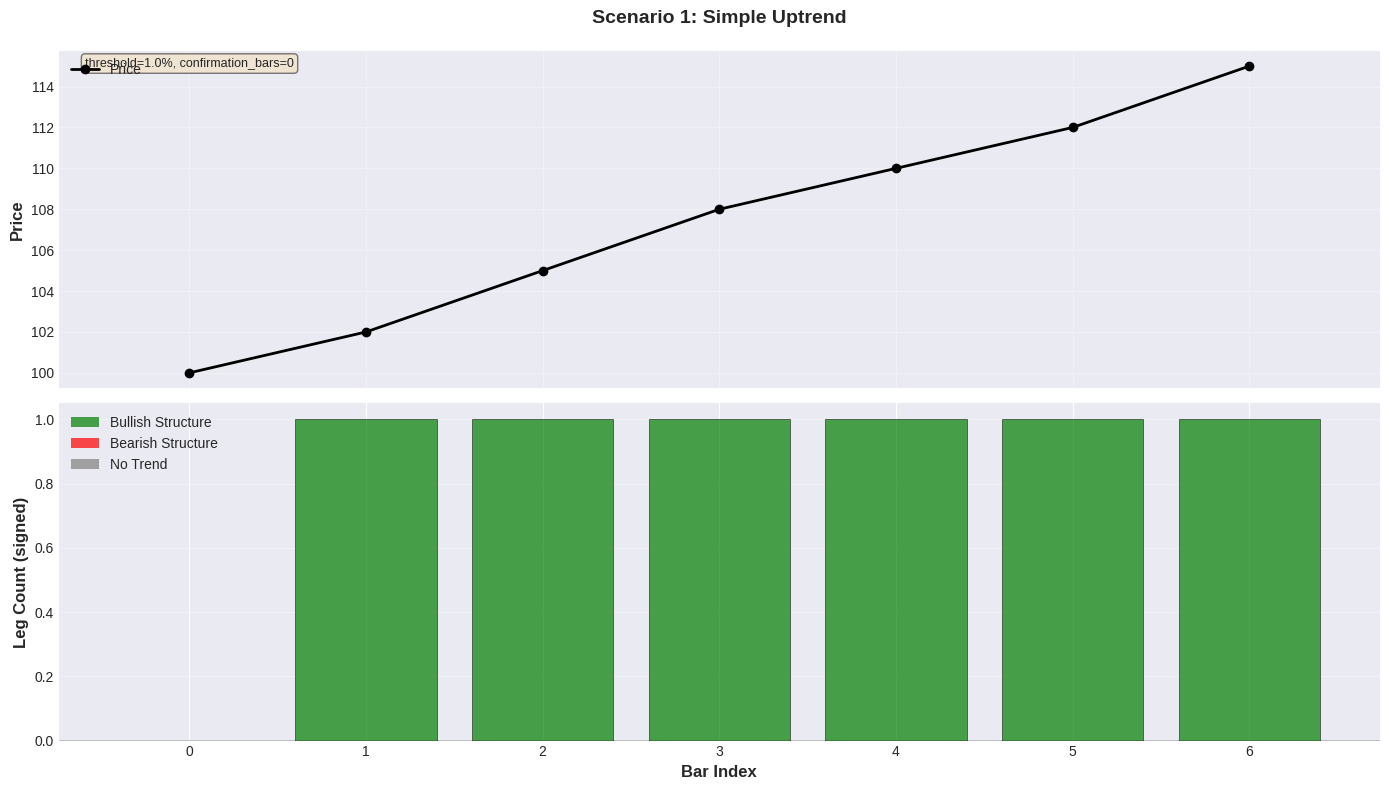

Price: [100. 102. 105. 108. 110. 112. 115.]
Legs:  [0. 1. 1. 1. 1. 1. 1.]

✓ All positive values = Bullish structure maintained


In [3]:
df1 = pd.DataFrame({"close": [100.0, 102.0, 105.0, 108.0, 110.0, 112.0, 115.0]})

result1 = zigzag_legs(df1, threshold=0.01, confirmation_bars=0)
plot_zigzag_legs(
    df1, result1, "Scenario 1: Simple Uptrend", threshold=0.01, confirmation_bars=0
)
plt.show()

print("Price:", df1["close"].values)
print("Legs: ", result1["zigzag_legs"].values)
print("\n✓ All positive values = Bullish structure maintained")

## Scenario 2: Simple Downtrend

Clean downtrend establishing bearish structure.

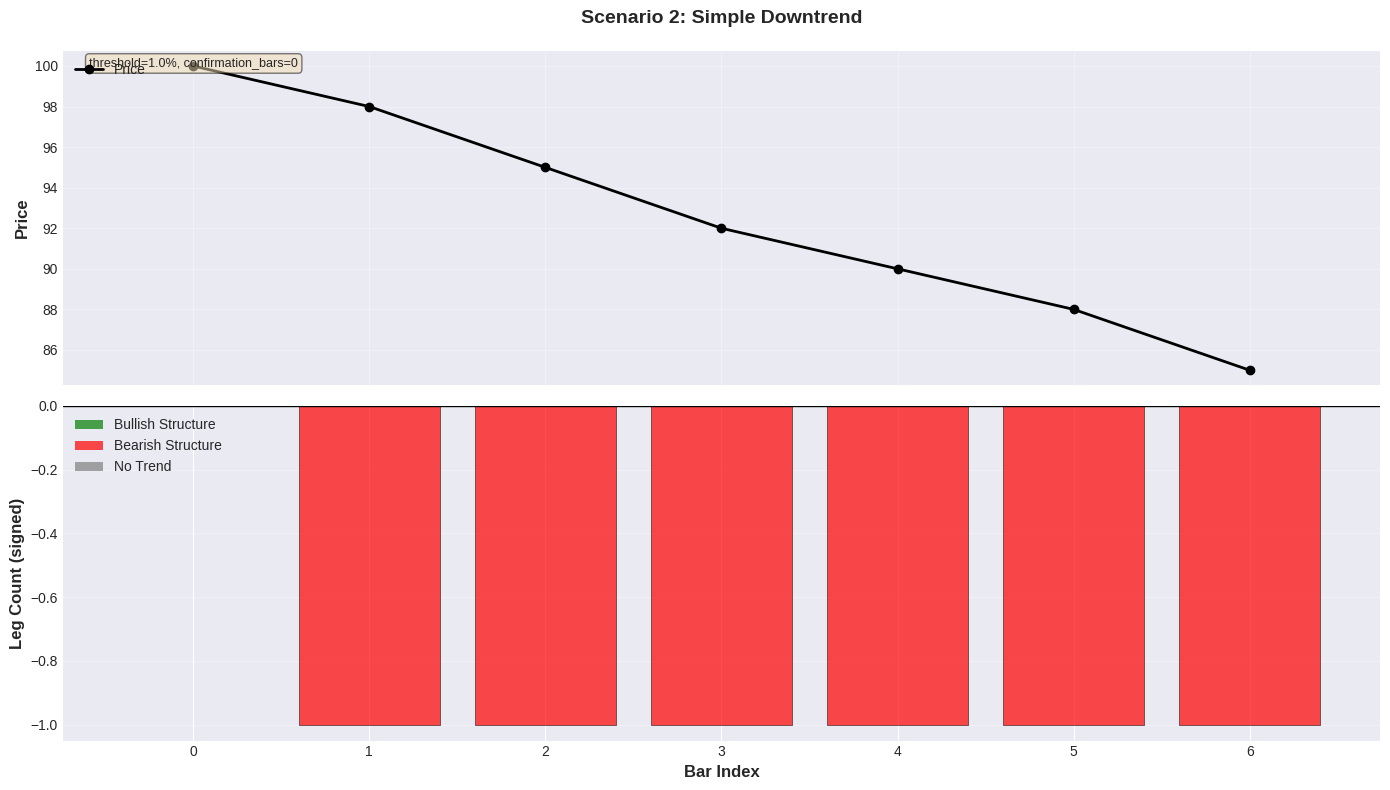

Price: [100.  98.  95.  92.  90.  88.  85.]
Legs:  [ 0. -1. -1. -1. -1. -1. -1.]

✓ All negative values = Bearish structure maintained


In [4]:
df2 = pd.DataFrame({"close": [100.0, 98.0, 95.0, 92.0, 90.0, 88.0, 85.0]})

result2 = zigzag_legs(df2, threshold=0.01, confirmation_bars=0)
plot_zigzag_legs(
    df2, result2, "Scenario 2: Simple Downtrend", threshold=0.01, confirmation_bars=0
)
plt.show()

print("Price:", df2["close"].values)
print("Legs: ", result2["zigzag_legs"].values)
print("\n✓ All negative values = Bearish structure maintained")

## Scenario 3: Multiple Legs - Higher Highs (CORRECTED)

**Key Discovery**: Leg count increments during **sustained, gradual movement**, not big single-bar jumps.

The algorithm uses "live counting" - it needs to see you actively moving through the previous high, bar by bar.

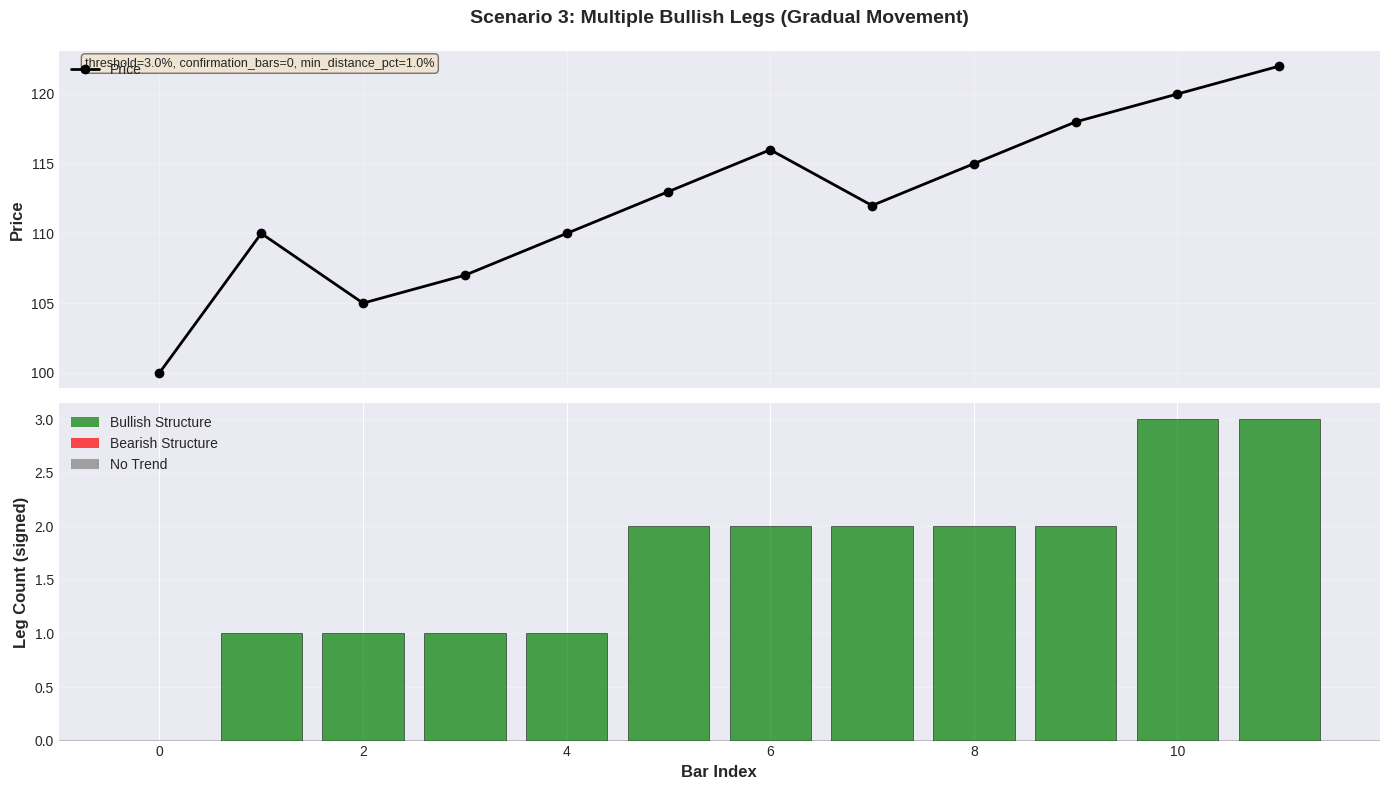

Price: [100. 110. 105. 107. 110. 113. 116. 112. 115. 118. 120. 122.]
Legs:  [0. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3.]

✓ Leg count increases: 1 → 2 → 3 (max: 3)

Why this works:
- Gradual movement (107 → 110 → 113) allows live counting
- Algorithm detects when price breaks previous high DURING upward movement
- Big single-bar jumps (105 → 116) would NOT increment the count


In [5]:
df3 = pd.DataFrame({
    "close": [
        100.0,  # Start
        110.0,  # +10% up - LEG 1 established
        105.0,  # Pullback (sets last_low=105)
        107.0,  # Start moving up
        110.0,  # Approaching previous high
        113.0,  # Breaking previous high (110) → LEG 2!
        116.0,  # Continue up
        112.0,  # Pullback (sets last_low=112)
        115.0,  # Start moving up
        118.0,  # Approaching previous high (116)
        120.0,  # Breaking previous high → LEG 3!
        122.0,  # Continue up
    ]
})

result3 = zigzag_legs(df3, threshold=0.03, confirmation_bars=0, min_distance_pct=0.01)
plot_zigzag_legs(
    df3,
    result3,
    "Scenario 3: Multiple Bullish Legs (Gradual Movement)",
    threshold=0.03,
    confirmation_bars=0,
    min_distance_pct=0.01,
)
plt.show()

print("Price:", df3["close"].values)
print("Legs: ", result3["zigzag_legs"].values)
print(f"\n✓ Leg count increases: 1 → 2 → 3 (max: {result3['zigzag_legs'].max():.0f})")
print("\nWhy this works:")
print("- Gradual movement (107 → 110 → 113) allows live counting")
print("- Algorithm detects when price breaks previous high DURING upward movement")
print("- Big single-bar jumps (105 → 116) would NOT increment the count")

## Scenario 4: Multiple Legs - Lower Lows (CORRECTED)

Same principle applies to bearish structure.

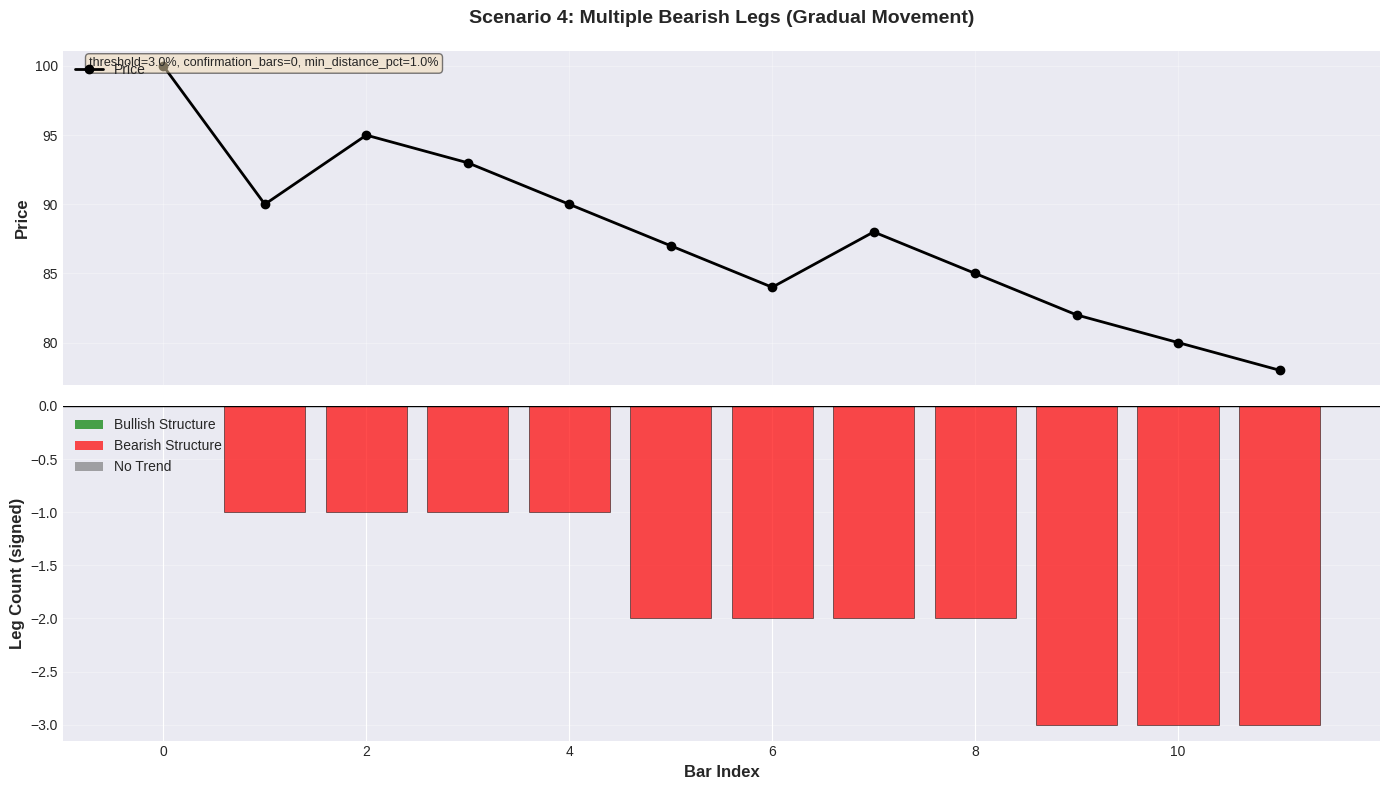

Price: [100.  90.  95.  93.  90.  87.  84.  88.  85.  82.  80.  78.]
Legs:  [ 0. -1. -1. -1. -1. -2. -2. -2. -2. -3. -3. -3.]

✓ Leg count increases: -1 → -2 → -3 (min: -3)


In [6]:
df4 = pd.DataFrame({
    "close": [
        100.0,  # Start
        90.0,  # -10% down - LEG 1 established
        95.0,  # Bounce (sets last_high=95)
        93.0,  # Start moving down
        90.0,  # Approaching previous low
        87.0,  # Breaking previous low (90) → LEG 2!
        84.0,  # Continue down
        88.0,  # Bounce (sets last_high=88)
        85.0,  # Start moving down
        82.0,  # Approaching previous low (84)
        80.0,  # Breaking previous low → LEG 3!
        78.0,  # Continue down
    ]
})

result4 = zigzag_legs(df4, threshold=0.03, confirmation_bars=0, min_distance_pct=0.01)
plot_zigzag_legs(
    df4,
    result4,
    "Scenario 4: Multiple Bearish Legs (Gradual Movement)",
    threshold=0.03,
    confirmation_bars=0,
    min_distance_pct=0.01,
)
plt.show()

print("Price:", df4["close"].values)
print("Legs: ", result4["zigzag_legs"].values)
print(
    f"\n✓ Leg count increases: -1 → -2 → -3 (min: {result4['zigzag_legs'].min():.0f})"
)

## Scenario 5: Trend Change (Bullish → Bearish)

Shows structure break when price drops below previous low.

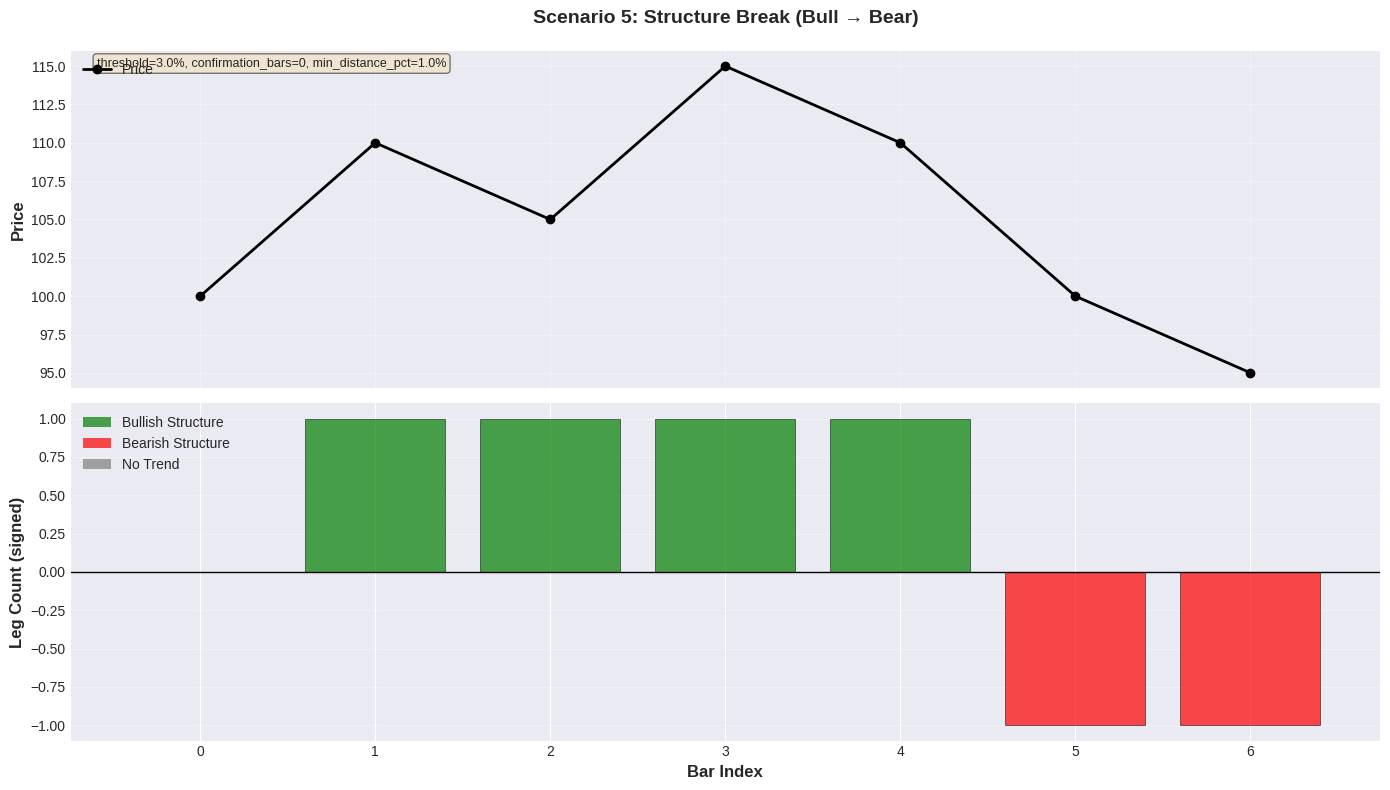

Price: [100. 110. 105. 115. 110. 100.  95.]
Legs:  [ 0.  1.  1.  1.  1. -1. -1.]

✓ Sign changes from positive (+1) to negative (-1) when structure breaks
  Structure break occurs when price drops below last_low (105)


In [7]:
df5 = pd.DataFrame({
    "close": [
        100.0,  # Start
        110.0,  # Bullish leg up
        105.0,  # Pullback (sets last_low=105)
        115.0,  # Higher high - confirms bullish
        110.0,  # Start of potential reversal
        100.0,  # BREAKS previous low (105) - STRUCTURE BREAK!
        95.0,  # Lower low - bearish confirmed
    ]
})

result5 = zigzag_legs(df5, threshold=0.03, confirmation_bars=0, min_distance_pct=0.01)
plot_zigzag_legs(
    df5,
    result5,
    "Scenario 5: Structure Break (Bull → Bear)",
    threshold=0.03,
    confirmation_bars=0,
    min_distance_pct=0.01,
)
plt.show()

print("Price:", df5["close"].values)
print("Legs: ", result5["zigzag_legs"].values)
print("\n✓ Sign changes from positive (+1) to negative (-1) when structure breaks")
print("  Structure break occurs when price drops below last_low (105)")

## Scenario 6: Threshold Sensitivity

Shows how different threshold values affect trend detection.

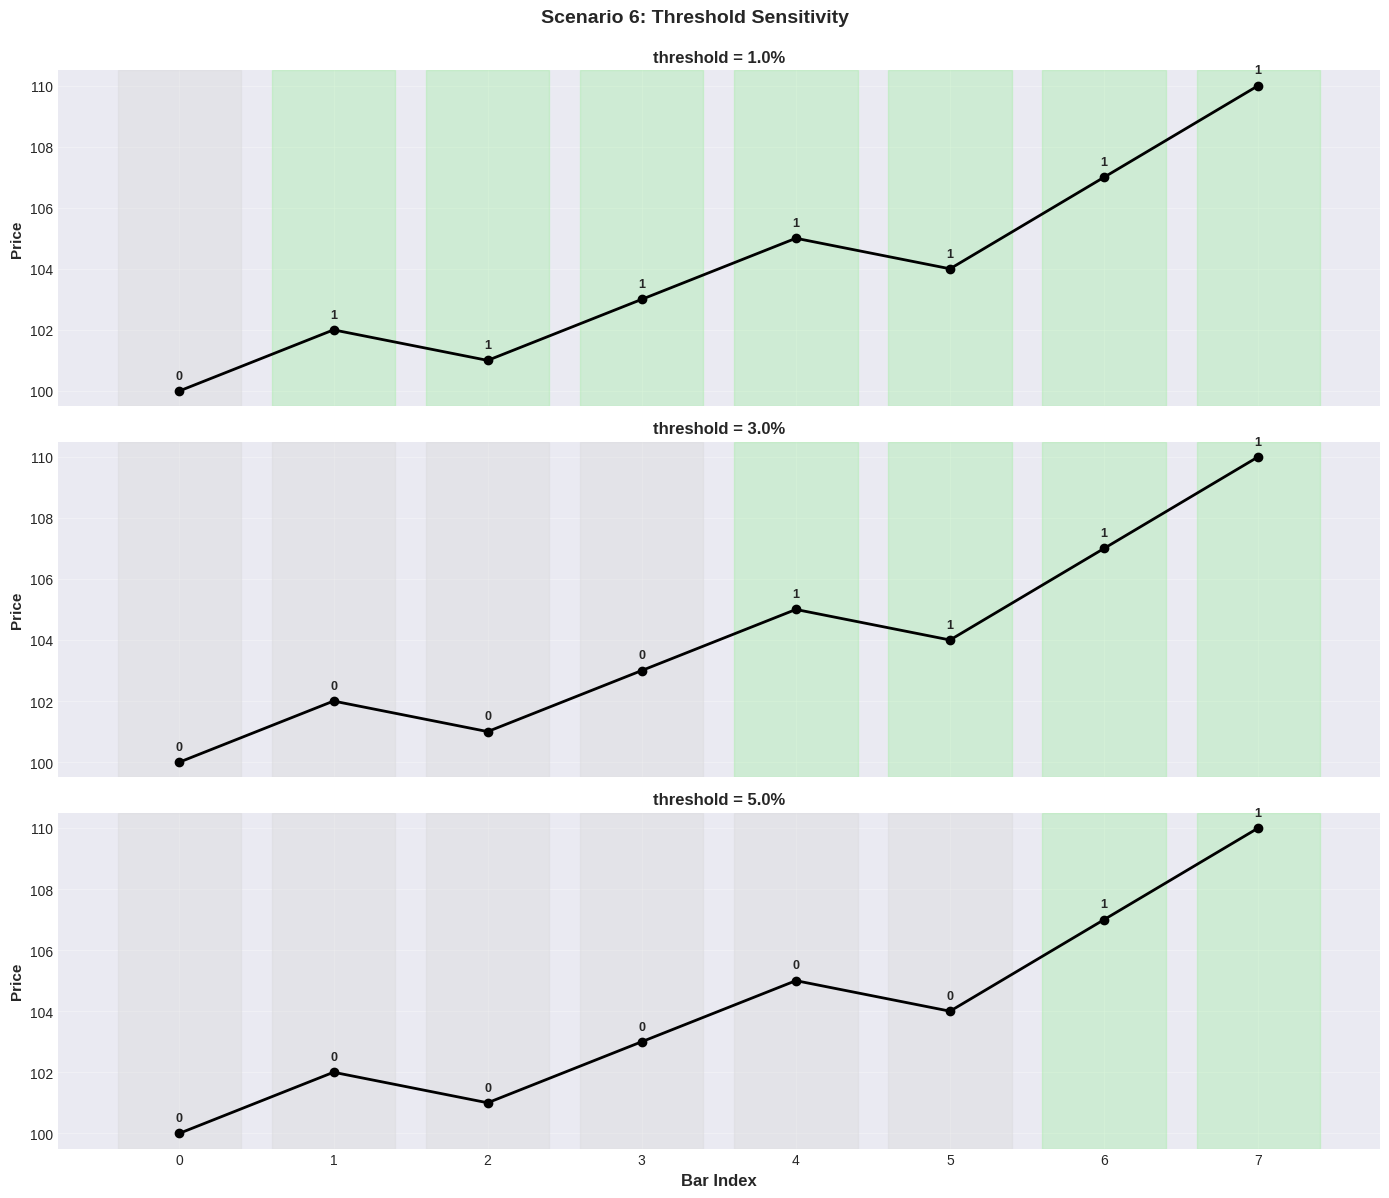

Price: [100. 102. 101. 103. 105. 104. 107. 110.]

With threshold=1%:  [0. 1. 1. 1. 1. 1. 1. 1.]
With threshold=3%:  [0. 0. 0. 0. 1. 1. 1. 1.]
With threshold=5%:  [0. 0. 0. 0. 0. 0. 1. 1.]

✓ Lower threshold = more sensitive = detects trend earlier
✓ Higher threshold = less sensitive = filters small moves


In [8]:
df6 = pd.DataFrame({"close": [100.0, 102.0, 101.0, 103.0, 105.0, 104.0, 107.0, 110.0]})

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for idx, thresh in enumerate([0.01, 0.03, 0.05]):
    result = zigzag_legs(df6, threshold=thresh, confirmation_bars=0)
    legs = result["zigzag_legs"].values

    ax = axes[idx]
    ax.plot(df6.index, df6["close"], "o-", color="black", linewidth=2, markersize=6)

    # Color background
    for i in range(len(legs)):
        color = (
            "lightgreen"
            if legs[i] > 0
            else "lightcoral"
            if legs[i] < 0
            else "lightgray"
        )
        ax.axvspan(i - 0.4, i + 0.4, alpha=0.3, color=color)

    ax.set_ylabel("Price", fontsize=11, fontweight="bold")
    ax.set_title(f"threshold = {thresh:.1%}", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3)

    # Add leg values
    for i, leg in enumerate(legs):
        ax.text(
            i,
            df6["close"].iloc[i] + 0.3,
            f"{int(leg)}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

axes[-1].set_xlabel("Bar Index", fontsize=12, fontweight="bold")
plt.suptitle(
    "Scenario 6: Threshold Sensitivity", fontsize=14, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

print("Price:", df6["close"].values)
print(
    "\nWith threshold=1%: ",
    zigzag_legs(df6, threshold=0.01, confirmation_bars=0)["zigzag_legs"].values,
)
print(
    "With threshold=3%: ",
    zigzag_legs(df6, threshold=0.03, confirmation_bars=0)["zigzag_legs"].values,
)
print(
    "With threshold=5%: ",
    zigzag_legs(df6, threshold=0.05, confirmation_bars=0)["zigzag_legs"].values,
)
print("\n✓ Lower threshold = more sensitive = detects trend earlier")
print("✓ Higher threshold = less sensitive = filters small moves")

## Scenario 7: Real-World Price Action with Multiple Trend Changes

Realistic scenario showing transitions between bullish and bearish structures.

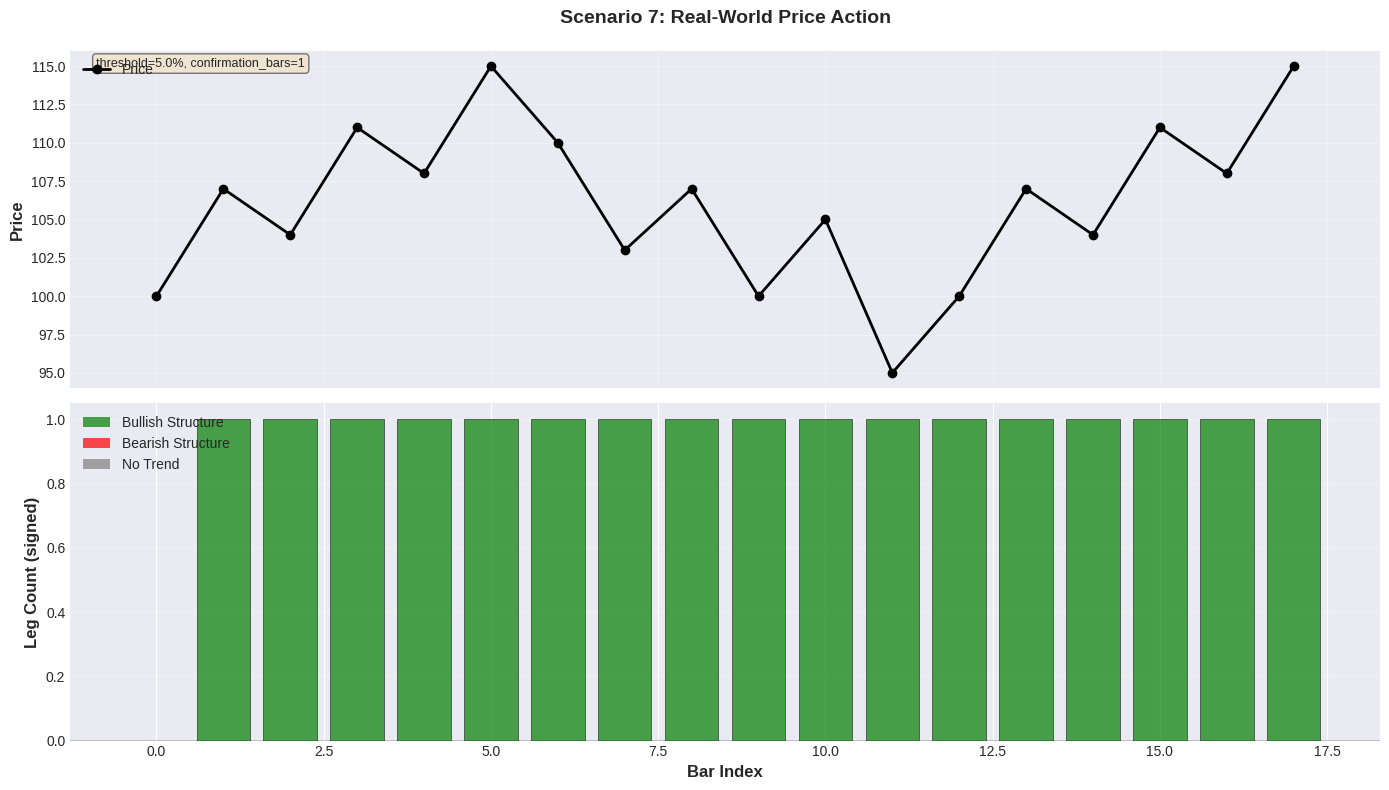

Price: [100 107 104 111 108 115 110 103 107 100 105  95 100 107 104 111 108 115]
Legs:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Structure analysis:
  Bullish bars: 17
  Bearish bars: 0
  Neutral bars: 1


In [9]:
df7 = pd.DataFrame({
    "close": [
        # Bullish phase
        100,
        107,
        104,
        111,
        108,
        115,
        # Transition to bearish (breaks below 104)
        110,
        103,
        107,
        100,
        105,
        95,
        # Transition back to bullish (breaks above 107)
        100,
        107,
        104,
        111,
        108,
        115,
    ]
})

result7 = zigzag_legs(df7, threshold=0.05, confirmation_bars=1)
plot_zigzag_legs(
    df7,
    result7,
    "Scenario 7: Real-World Price Action",
    threshold=0.05,
    confirmation_bars=1,
)
plt.show()

print("Price:", df7["close"].values)
print("Legs: ", result7["zigzag_legs"].values)

bullish_bars = (result7["zigzag_legs"] > 0).sum()
bearish_bars = (result7["zigzag_legs"] < 0).sum()
neutral_bars = (result7["zigzag_legs"] == 0).sum()

print("\nStructure analysis:")
print(f"  Bullish bars: {bullish_bars}")
print(f"  Bearish bars: {bearish_bars}")
print(f"  Neutral bars: {neutral_bars}")

## Scenario 8: Random Walk (1000 bars)

Performance test showing behavior on realistic random price data.

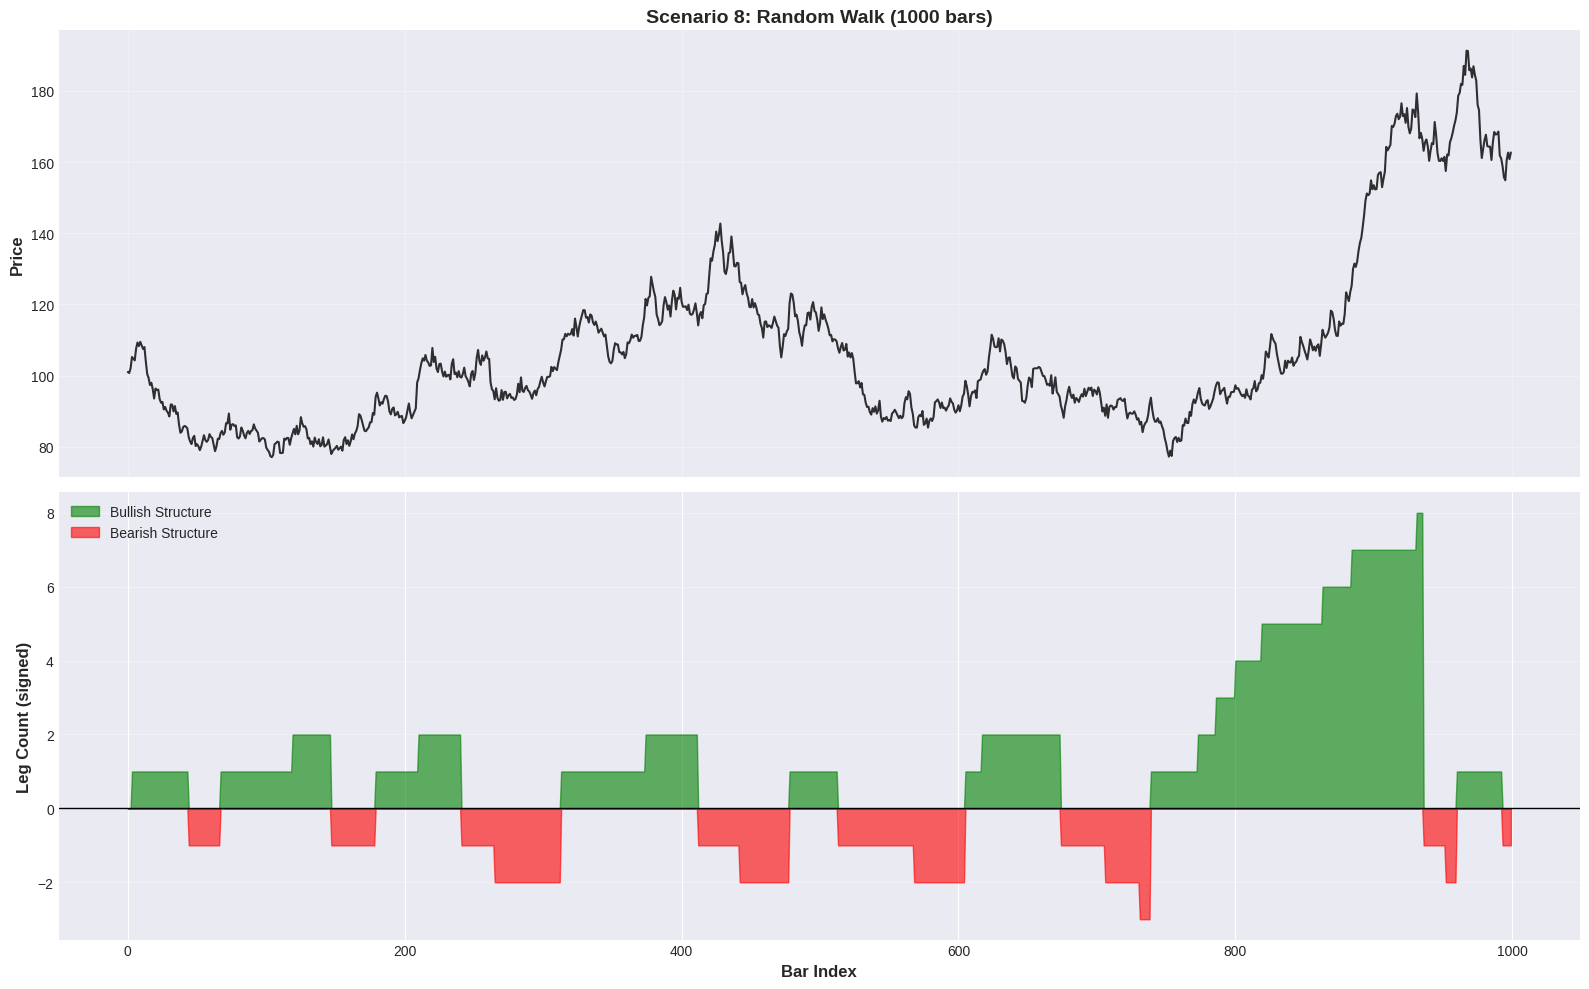

Total bars: 1000
Bullish bars: 616 (61.6%)
Bearish bars: 381 (38.1%)
Neutral bars: 3 (0.3%)
Max bullish leg count: 8
Max bearish leg count: -3
Number of trend changes: 16


In [10]:
# Generate random walk
np.random.seed(42)
returns = np.random.normal(0.0001, 0.02, 1000)
prices = 100.0 * np.exp(np.cumsum(returns))
df8 = pd.DataFrame({"close": prices})

result8 = zigzag_legs(df8, threshold=0.03, confirmation_bars=2, min_distance_pct=0.01)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Price plot
ax1.plot(df8.index, df8["close"], linewidth=1.5, color="black", alpha=0.8)
ax1.set_ylabel("Price", fontsize=12, fontweight="bold")
ax1.set_title("Scenario 8: Random Walk (1000 bars)", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Legs plot with fill
legs = result8["zigzag_legs"].values
positive_legs = np.where(legs > 0, legs, 0)
negative_legs = np.where(legs < 0, legs, 0)

ax2.fill_between(
    df8.index, 0, positive_legs, alpha=0.6, color="green", label="Bullish Structure"
)
ax2.fill_between(
    df8.index, 0, negative_legs, alpha=0.6, color="red", label="Bearish Structure"
)
ax2.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax2.set_ylabel("Leg Count (signed)", fontsize=12, fontweight="bold")
ax2.set_xlabel("Bar Index", fontsize=12, fontweight="bold")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Statistics
print(f"Total bars: {len(df8)}")
print(f"Bullish bars: {(legs > 0).sum()} ({(legs > 0).sum() / len(legs) * 100:.1f}%)")
print(f"Bearish bars: {(legs < 0).sum()} ({(legs < 0).sum() / len(legs) * 100:.1f}%)")
print(f"Neutral bars: {(legs == 0).sum()} ({(legs == 0).sum() / len(legs) * 100:.1f}%)")
print(f"Max bullish leg count: {legs.max():.0f}")
print(f"Max bearish leg count: {legs.min():.0f}")
print(f"Number of trend changes: {np.sum(np.diff(np.sign(legs)) != 0)}")

## Scenario 9: Parameter Comparison Heatmap

Visual comparison of how parameter combinations affect leg counting.

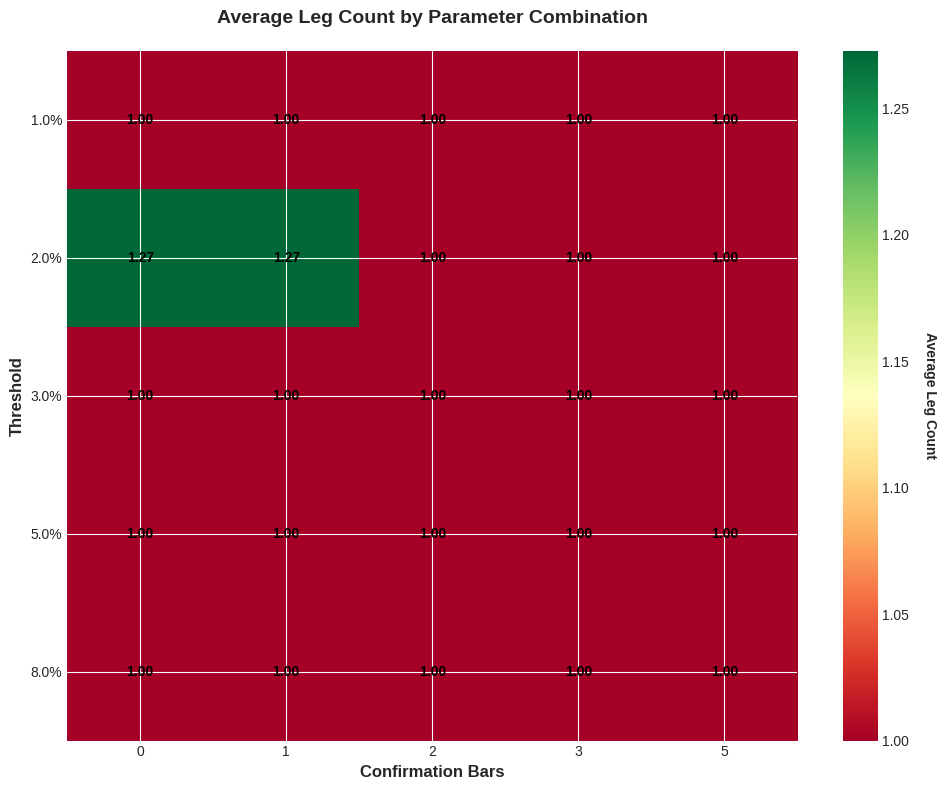

Test data: [100 105 103 110 108 115 112 120 118 125 122 130]

Interpretation:
- Higher values (green) = More sensitive, detects more structure
- Lower values (red) = Less sensitive, filters more noise
- Lower threshold + lower confirmation = Most sensitive
- Higher threshold + higher confirmation = Most conservative


In [11]:
# Test data: trending market with pullbacks
df9 = pd.DataFrame({
    "close": [100, 105, 103, 110, 108, 115, 112, 120, 118, 125, 122, 130]
})

# Test different parameter combinations
thresholds = [0.01, 0.02, 0.03, 0.05, 0.08]
confirmations = [0, 1, 2, 3, 5]

results_matrix = np.zeros((len(thresholds), len(confirmations)))

for i, threshold in enumerate(thresholds):
    for j, conf in enumerate(confirmations):
        result = zigzag_legs(df9, threshold=threshold, confirmation_bars=conf)
        legs = result["zigzag_legs"].values
        non_zero_legs = legs[legs != 0]
        if len(non_zero_legs) > 0:
            results_matrix[i, j] = np.mean(np.abs(non_zero_legs))
        else:
            results_matrix[i, j] = 0

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(results_matrix, cmap="RdYlGn", aspect="auto")

ax.set_xticks(np.arange(len(confirmations)))
ax.set_yticks(np.arange(len(thresholds)))
ax.set_xticklabels(confirmations)
ax.set_yticklabels([f"{t:.1%}" for t in thresholds])

ax.set_xlabel("Confirmation Bars", fontsize=12, fontweight="bold")
ax.set_ylabel("Threshold", fontsize=12, fontweight="bold")
ax.set_title(
    "Average Leg Count by Parameter Combination", fontsize=14, fontweight="bold", pad=20
)

# Add values to cells
for i in range(len(thresholds)):
    for j in range(len(confirmations)):
        text = ax.text(
            j,
            i,
            f"{results_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="black",
            fontweight="bold",
        )

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Leg Count", rotation=270, labelpad=20, fontweight="bold")

plt.tight_layout()
plt.show()

print("Test data:", df9["close"].values)
print("\nInterpretation:")
print("- Higher values (green) = More sensitive, detects more structure")
print("- Lower values (red) = Less sensitive, filters more noise")
print("- Lower threshold + lower confirmation = Most sensitive")
print("- Higher threshold + higher confirmation = Most conservative")

## Summary & Key Learnings

### 1. Leg Counting Mechanism
- **"Live counting"** occurs during active trending movement
- Requires **gradual, sustained movement** through previous highs/lows
- Big single-bar jumps don't trigger leg increments

### 2. Structure vs. Price Direction
- Positive legs = Bullish structure (higher highs + higher lows)
- Negative legs = Bearish structure (lower lows + lower highs)
- Sign changes only occur on structure breaks

### 3. Parameters Impact
- **threshold**: Minimum move to trigger reversal (lower = more sensitive)
- **confirmation_bars**: Delay before confirming reversal (higher = more lag, fewer false signals)
- **min_distance_pct**: Filters tiny pivot updates (subtle effect)

### 4. Practical Applications
- Trend identification and tracking
- Elliott Wave leg counting
- Structure break detection
- Distinguishing corrections from reversals

### 5. Important Caveats
- This is NOT a simple zigzag indicator
- Tracks market structure, not every price swing
- Requires proper parameter tuning for your timeframe
- Some effects (confirmation, min_distance) are subtle in short examples

## Feature Showcase: Safety & Configuration

In [ ]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator.legs import zigzag_legs

# 1. Configuration with .Config()
print(f"--- Custom zigzag_legs Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_zigzag_legs = zigzag_legs.Config(threshold=0.05).make()
print(f"Created: {custom_zigzag_legs}")

# 2. Validation Safety
print(f"
--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (missing column)
    invalid_data = pd.DataFrame({'volume': [100]}) # Missing close
    print("Attempting calculation with invalid inputs...")
    zigzag_legs(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected:
  {e}")
